In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lgdo import lh5, VectorOfVectors, WaveformTable, Table, ArrayOfEqualSizedArrays, Array
from numba import guvectorize
from dspeed.utils import numba_defaults_kwargs as nb_kwargs

In [66]:
%matplotlib ipympl

In [71]:
# This processor will inject a Gumbel distribution into the input waveform.
@guvectorize(
    [
        # Define function signatures for single-precision (float32) and double-precision (float64).
        "void(float32[:], float32, float32, float32, float32[:])",
        "void(float64[:], float64, float64, float64, float64[:])",
    ],
    # Dimension signature: (n) is the input array, (),(),() are scalar inputs, and ->(n) is the output array.
    "(n),(),(),()->(n)",
    **nb_kwargs,  # Additional arguments (e.g., target="parallel" for parallelization).
)
def gumbel_inject(wf_in, a, t0, beta, wf_out):
    """
    Injects a Gumbel distribution into the waveform `wf_in`, modifying it in place in `wf_out`.
    
    Parameters:
    - wf_in: Input waveform (1D array).
    - a: Amplitude of the Gumbel distribution.
    - t0: Temporal centroid of the Gumbel distribution.
    - beta: Scale parameter (controls spread of the Gumbel distribution).
    - wf_out: Output waveform (1D array), modified by adding the Gumbel distribution.
    """
    
    # Initialize the output array with NaN values.
    wf_out[:] = np.nan

    # Early exit if any of the inputs contain NaN values (invalid inputs).
    if (
        np.isnan(wf_in).any()  # Check for NaNs in the input waveform.
        or np.isnan(a)         # Check for NaN in amplitude.
        or np.isnan(t0)        # Check for NaN in the centroid.
        or np.isnan(beta)      # Check for NaN in the scale parameter.
    ):
        return  # If any input is invalid, exit without modifying wf_out.

    # Copy the input waveform into the output array as a starting point.
    wf_out[:] = wf_in[:]

    # Define the range of indices over which the Gumbel distribution will be applied.
    # Start injecting the distribution at 2 beta below the centroid (t0).
    start = t0  # Initial guess for start index.
    mu = t0 + (2 * beta)  # Adjust centroid based on beta.
    end = mu + 8 * beta  # End injecting at ~8 beta above the centroid.

    # Ensure the range is within valid waveform boundaries.
    if start < 0:  # Clamp start to 0 if it falls below array bounds.
        start = 0
    if end > len(wf_in):  # Clamp end to the array's length if it exceeds bounds.
        end = len(wf_in)

    # Loop through the specified range and add the Gumbel distribution to wf_out.
    for i in range(start, end):
        # Calculate the normalized variable z for the Gumbel function.
        z = (i - mu) / beta
        
        # Gumbel distribution PDF:
        # (a / beta) scales the distribution by amplitude and scale factor.
        # np.exp(-(z + np.exp(-z))) computes the Gumbel function at index i.
        wf_out[i] += (a / beta) * np.exp(-(z + np.exp(-z)))

In [72]:
# we'll just use basic white noise as the basis of our waveforms, this is slightly different to the 
# waveform data we have where the lower frequencies are higher
mean = 0
std = 20
num_samples = 1000 #number of points
wf_len = 32 #the number of points in the wavefunction
samples = np.random.normal(mean, std, size=(num_samples, wf_len))
#this create white noise


In [73]:
# shift samples to mean value 2000 (roughly corresponding to data)
mean = 2000
std = 20
samples += np.random.normal(mean, std, size=(num_samples, 1))

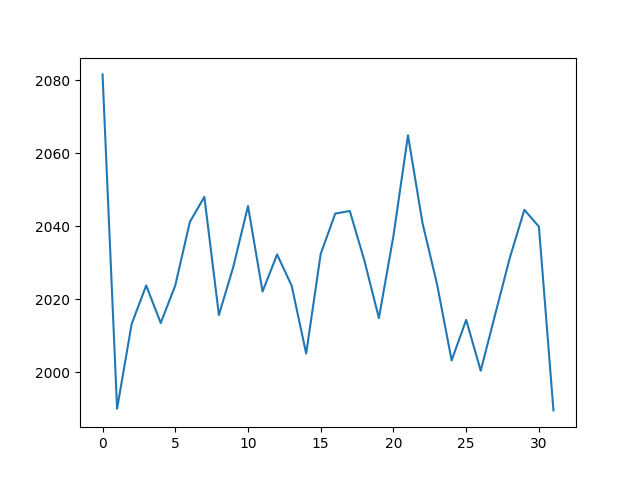

In [74]:
plt.figure()
plt.plot(samples[0,:])
plt.show()

In [75]:
# initialise the output object
wf_gumbel = np.zeros_like(samples)

In [76]:
# fix amplitude and width, vary t0 using uniform distribution
amplitude = 1000 #the bigger the amplitude, the clearer the peak. a small amplitude (>500) leads to an unclear peak. 
width = 1 #the smaller the width, the clearer the peak. a big width (>1.5) leads to an unclear peak.
t0_start = 11
shift = 5
t0 = np.random.uniform(t0_start,t0_start+shift,num_samples) #this indicates where the gumbel peak starts
t0_error = np.random.normal(

In [77]:
for i in range(num_samples):
    gumbel_inject(samples[i,:], amplitude, t0[i], width, wf_gumbel[i,:])

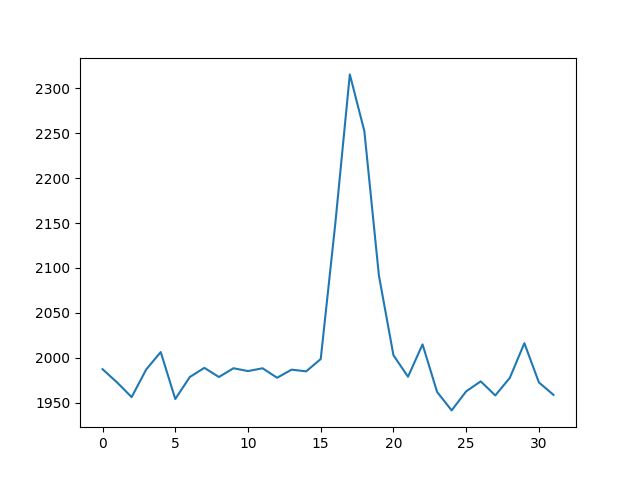

In [78]:
plt.figure()
plt.plot(wf_gumbel[100,:])
plt.show()

In [79]:
full_interval = np.max(t0) - np.min(t0)
num_steps = 5
step_size = full_interval/num_steps
shifts_list = np.floor((t0-np.min(t0))/step_size).astype(int)

In [ ]:
t - t0

[[ 0  0  1 ... 28 29 30]
 [ 0  0  1 ... 28 29 30]
 [ 0  0  1 ... 28 29 30]
 ...
 [ 0  0  1 ... 28 29 30]
 [ 0  0  1 ... 28 29 30]
 [ 0  0  0 ... 27 28 29]]
[2972. 1000. 1000. ...  604.  409.  209.]


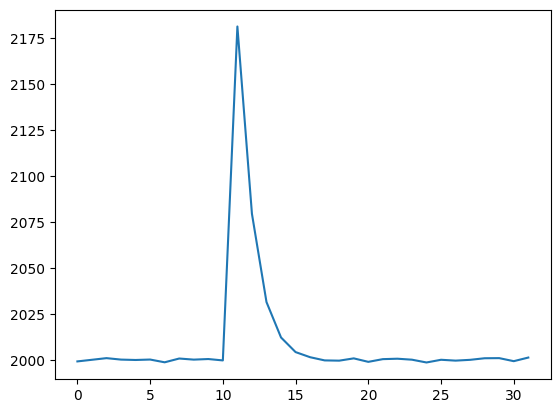

In [51]:
wf_extended = np.zeros(wf_len)
counts = np.zeros(wf_len)
base = np.arange(wf_len)
shifts = shifts_list[:, None]  # Shape (num_waveforms, 1) for broadcasting

# Calculate indices for all waveforms and clip them
indexes = np.clip(base - shifts, 0, wf_len - 1)  # Shape (num_waveforms, wf_len)
print(indexes)

# Accumulate wf_gumbel values into wf_extended
np.add.at(wf_extended, indexes, wf_gumbel)

# Accumulate contributions into counts
np.add.at(counts, indexes, 1)

print(counts)
# Plot the result
plt.figure()
plt.plot(wf_extended / counts)
plt.show()

In [80]:
# Initialize extended arrays
wf_extended = np.zeros(wf_len * 5)
counts = np.zeros(wf_len * 5)
base = np.arange(wf_len)

upsample = 5
shifts_list = np.floor((t0-10)*upsample).astype(int)
shifts = shifts_list[:, None]  # Shape (num_waveforms, 1) for broadcasting
indices = base * upsample - shifts  # Shape (num_waveforms, wf_len)

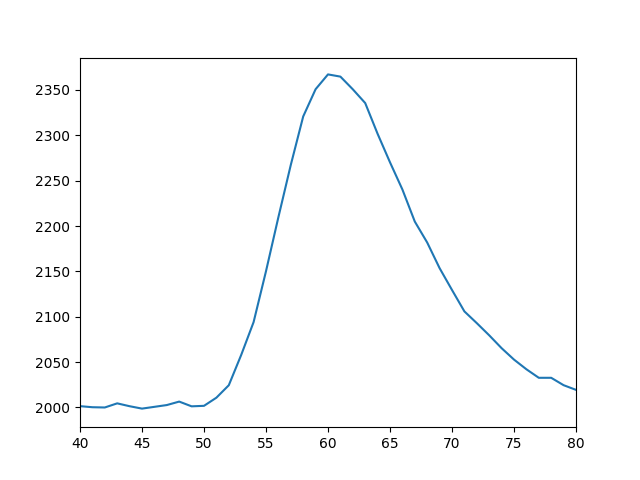

In [81]:
shifts = shifts_list[:, None]  # Shape (num_waveforms, 1) for broadcasting
indices = base * upsample - shifts  # Shape (num_waveforms, wf_len)

# Scatter-add values to wf_extended and counts
for i in range(num_samples):
    wf_extended[indices[i]] += wf_gumbel[i,:]
    counts[indices[i]] += np.ones(wf_len)

# Plot the result
plt.figure()
plt.plot(wf_extended / counts)
plt.xlim([40,80])
plt.show()

In [82]:
len(wf_extended)

160

In [63]:
shifts_list

array([14, 13, 14, ..., 10, 10, 17])

In [38]:
sim_values =  ArrayOfEqualSizedArrays(nda=wf_gumbel,dtype=np.uint16)

In [39]:
sim_wfs = WaveformTable(values= sim_values, dt=4.8, dt_units="ns",t0=0, t0_units="ns")

In [40]:
table = Table({"waveform":sim_wfs})


In [115]:
from pathlib import Path

In [116]:
file_path = Path("../sim_data/raw/sim_wfs.lh5")
file_path.parent.mkdir(parents=True, exist_ok=True)
lh5.write(table,
          name="raw",
          lh5_file=file_path
         )